In [197]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [1]:
import pandas as pd

In [174]:
df = pd.read_csv('/Users/mr.tian/Desktop/AB_US_2020.csv', low_memory=False)

In [175]:
df.drop(columns=['id', 'host_id', 'name', 'last_review', 'host_name'], axis=1, inplace=True)

In [176]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(df['reviews_per_month'].median())

In [177]:
df.drop(columns=['neighbourhood_group'], axis=1, inplace=True)

In [178]:
for col in df.columns:
    print(df[col].name, df[col].nunique())

neighbourhood 1450
latitude 145091
longitude 145243
room_type 4
price 1975
minimum_nights 169
number_of_reviews 660
reviews_per_month 1242
calculated_host_listings_count 142
availability_365 366
city 28


In [179]:
df = pd.get_dummies(df, columns=['room_type'], drop_first=True, dtype=int)

In [180]:
df['minimum_nights'] = df['minimum_nights'].clip(upper=365)

In [181]:
df = df.dropna().copy()

In [182]:
from category_encoders import TargetEncoder

In [183]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [189]:
X = df.drop(columns='price', axis=1)
y = np.log1p(df['price']) 

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [191]:
from category_encoders import TargetEncoder

te = TargetEncoder(cols=['city', 'neighbourhood'])
X_train = X_train.copy()
X_test = X_test.copy()

X_train[['city', 'neighbourhood']] = te.fit_transform(X_train[['city','neighbourhood']], y_train)
X_test[['city', 'neighbourhood']] = te.transform(X_test[['city','neighbourhood']])

In [192]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [198]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
model = LinearRegression()
model.fit(X_train_scaled, y_train)
pred = model.predict(X_test_scaled)
print(r2_score(y_test, pred))

0.373075939443947


In [195]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=25,
    min_samples_leaf=5,  
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print(r2_score(y_test, pred_rf))

0.5739531443697904


In [196]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
print(r2_score(y_test, pred))

0.5792918176805576


In [201]:
importances = rf.feature_importances_

feat_imp = pd.Series(importances, index=X_train.columns)
feat_imp = feat_imp.sort_values(ascending=False)

print(feat_imp)

room_type_Private room            0.226710
neighbourhood                     0.202947
longitude                         0.091478
latitude                          0.087085
reviews_per_month                 0.062759
number_of_reviews                 0.058638
calculated_host_listings_count    0.058284
availability_365                  0.057304
minimum_nights                    0.053280
room_type_Shared room             0.050701
city                              0.048401
room_type_Hotel room              0.002413
dtype: float64


In [206]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

kf = KFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline([
    ('te', TargetEncoder(cols=['city', 'neighbourhood'])),
    ('model', xgb)
])

cv_scores = cross_val_score(
    pipe,
    X,
    y,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    error_score='raise'
)

print("CV R2 scores: ", cv_scores)
print("Mean R2: ", cv_scores.mean())
print("Std R2: ", cv_scores.std())

CV R2 scores:  [ 0.26735863 -0.43627652  0.45968884  0.39394441  0.29015126]
Mean R2:  0.19497332443322882
Std R2:  0.32324561242427213


In [208]:
pipe.fit(X, y)

,steps,"[('te', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,"['city', 'neighbourhood']"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20


100%|===================| 225974/226030 [54:04<00:00]        

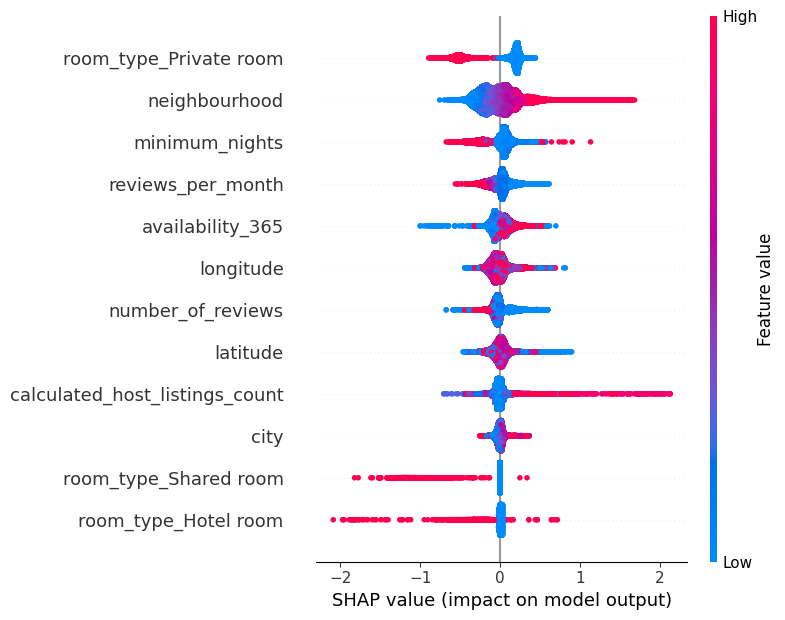

In [211]:
import shap

te = pipe.named_steps['te']
model = pipe.named_steps['model']

X_enc = te.transform(X)

explainer = shap.Explainer(model, X_enc)
shap_values = explainer(X_enc)

plt.savefig("/Users/mr.tian/Desktop/airbnb_images/pred_vs_actual_log.png",
            dpi=300, bbox_inches="tight")

shap.summary_plot(shap_values, X_enc)

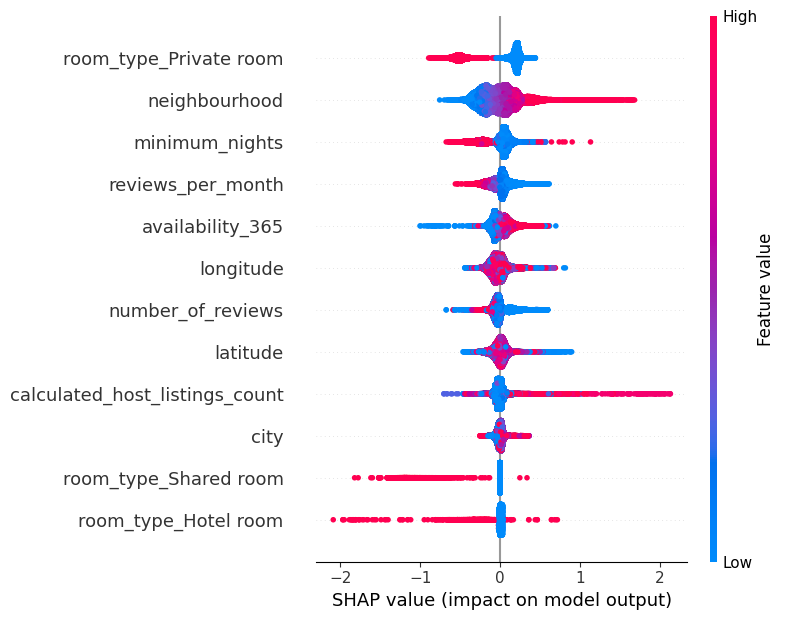

In [225]:
import os
import matplotlib.pyplot as plt

desktop = os.path.join(os.path.expanduser("~"), "Desktop")
save_dir = os.path.join(desktop, "airbnb_images")
os.makedirs(save_dir, exist_ok=True)

shap.summary_plot(shap_values, X_enc, show=False)
plt.savefig(os.path.join(save_dir, "shap_summary.png"),
            dpi=300, bbox_inches="tight")
plt.show()

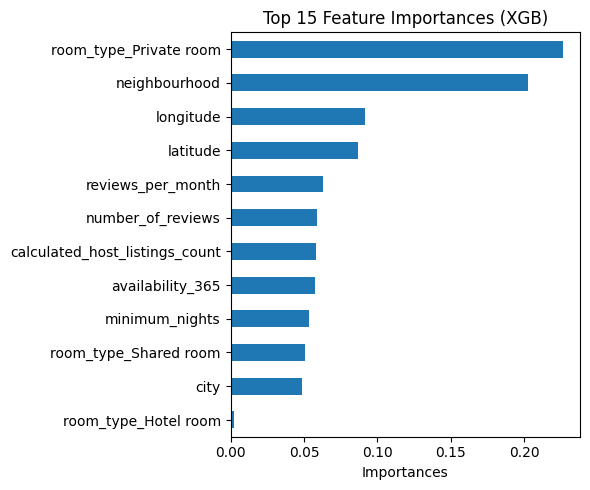

In [224]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
feat_imp.head(15).sort_values().plot(kind='barh')
plt.title(f"Top {15} Feature Importances (XGB)")
plt.xlabel('Importances')
plt.tight_layout()
plt.savefig("/Users/mr.tian/Desktop/airbnb_images/top_15_features.png",
            dpi=300, bbox_inches="tight")
plt.show()

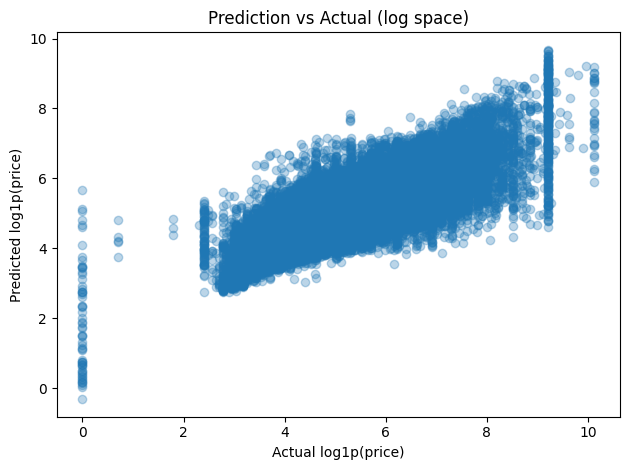

In [223]:
y_pred = pipe.predict(X)

plt.figure()
plt.scatter(y, y_pred, alpha=0.3)
plt.xlabel("Actual log1p(price)")
plt.ylabel("Predicted log1p(price)")
plt.title("Prediction vs Actual (log space)")
plt.tight_layout()
plt.savefig("/Users/mr.tian/Desktop/airbnb_images/pred_vs_actual_log.png",
            dpi=300, bbox_inches="tight")
plt.show()